Projeto de Interpretação e Classificação dos dados da Camada II-III do NeuronalSys
----------------------------------------------------------------------------------

## Introdução

### Objetivos

### Agenda

1. Leitura dos dados de frequência e análise;
2. Interpretação de qual melhor método para ser utilizado;
3. Escolha de dois métodos
4. Aplicação dos métodos
5. Resultados
6. Conclusões

## Execução desse notebook
Para executar esse projeto é necessário:
- Python 3.5
- jupyter
- numpy
- scipy
- scikit-learn
- matplotlib

Como preparar o ambiente de execução (ubuntu linux):

1. Instalar **pip** e Python 3.5
```
$ sudo apt-get install python3.5-dev
$ sudo apt-get install pip
```

2. Se não quiser usar virtualenv, pule essa etapa:
```
$ sudo pip install virtualenv
$ mkdir <nomedoprojeto>
$ cd <nomedoprojeto>
$ virtualenv venv --p /usr/bin/python3.5
$ source venv/bin/activate
```
Nesse momento o seu terminal ficará associado ao ambiente python do virtualenv.

3. Instalar as libs (se não usar virtualenv tem que colocar **sudo**)
```
$ pip install numpy
$ pip install scipy
$ pip install scikit-learn
$ pip install matplotlib
$ pip install jupyter
```

4. Execute o jupyter no mesmo local do arquivo Projeto.ipynb
```
$ jupyter notebook &
```

5. A execução do _jupyter_ irá abrir um browser com um navegador de arquivos. Escolha este notebook (Projeto.ipynb)
e ele permitirá a edição das celulas.

6. Uma versão em formato script do código está disponivel no arquivo projeto.py na pasta **scripts/**. Ela pode ser executada da seguinte maneira:
```
cd scripts/
python projeto.py --window 120
ou python projeto.py --load results.csv # para carregar o ultimo resultado feito
```

## Obtenção dos dados

Os dados foram obtidos através de uma modificação no NeuronalSys, em que foi possível geral um conjunto de dados para treinamento, teste e validação de métodos de classificação. Esse conjunto foi gerado no formato coluna x linha x tempo. O script (encontrado na pasta scripts) map_reduce.py, converte esses arquivos para uma representação de frequência.

Exemplo de uso do script
```bash
# python map_reduce.py dir_com_arquivos_de_entrada dir_para_arquivos_de_saida
python map_reduce.py ../data/raw_activation_maps/ ../data/freqs_series/
```

## Referencias
[k-shape clustering time series](http://www.cs.columbia.edu/~gravano/Papers/2015/sigmod2015.pdf)

[Pattern recognition in time series](https://pdfs.semanticscholar.org/2f5a/4b8b158117928e9eee7ac6ce7da291ec9bd2.pdf)

[Making Time-series Classification More Accurate Using Learned Constraints](http://www.cs.ucr.edu/~eamonn/RATANAMC.pdf)

[Everything you know about Dynamic Time Warping is Wrong](http://wearables.cc.gatech.edu/paper_of_week/DTW_myths.pdf)


## Interpretação

O código abaixo será usado pelas outras _cells_ no restante do _notebook_ então é importante que ele seja sempre executado, quando o _notebook_ for atualizado:

In [1]:
import os

import numpy as np
import pandas as pd

# Visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

shapes = ('square', 'triangle', 'hbar', 'vbar')

### Preparando o conjunto de dados

In [2]:
import glob

FREQS_DATA_DIR = os.path.join('..', 'data', 'freqs_series')
print(FREQS_DATA_DIR)

lsamples = []
class_ = []
for shape in shapes:  
    pattern = os.path.join(FREQS_DATA_DIR, '%s_*.dat' % shape)
    print(pattern)
    files = glob.glob(pattern)    
    
    for i, filename in enumerate(files):
        sdf = pd.read_csv(filename, sep=',', header=None, names=['time', 'freq'])
        sample = np.zeros(3000)
        sample[sdf.time] = sdf.freq
        lsamples.append(sample)
        class_.append(shape)
    
df = np.array(lsamples)
cldf = np.array(class_)

../data/freqs_series
../data/freqs_series/square_*.dat
../data/freqs_series/triangle_*.dat
../data/freqs_series/hbar_*.dat
../data/freqs_series/vbar_*.dat


### Visualização

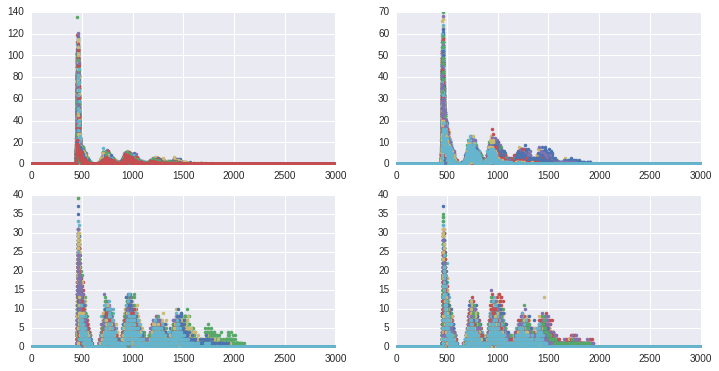

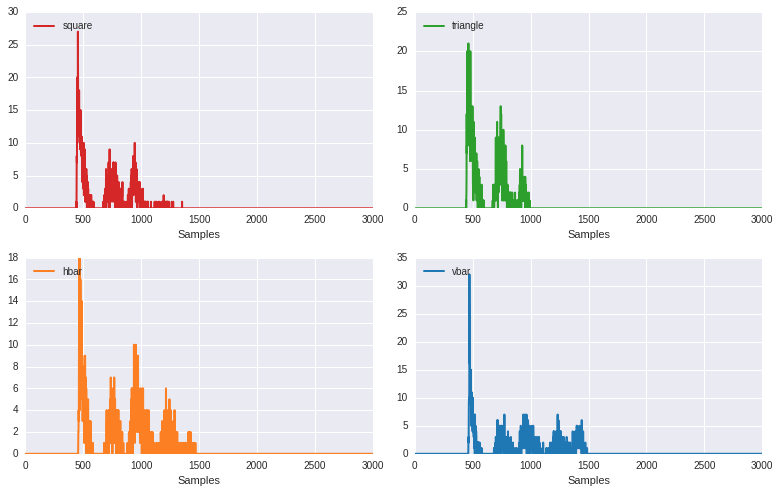

In [4]:
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
_ = ax1.plot(df[cldf == 'square',:].T, '.', label='square')
_ = ax2.plot(df[cldf == 'triangle',:].T, '.', label='triangle') 
_ = ax3.plot(df[cldf == 'vbar',:].T, '.', label='vbar')
_ = ax4.plot(df[cldf == 'hbar',:].T, '.', label='hbar')

plt.figure(figsize=(11,7))
colors = ['#D62728','#2C9F2C','#FD7F23','#1F77B4']

for i, r in enumerate([10, 220, 350, 500]):
    plt.subplot(2,2,i+1)
    plt.plot(df[r, :], label=cldf[r], color=colors[i], linewidth=2)
    plt.xlabel('Samples')
    plt.legend(loc='upper left')
    plt.tight_layout()

### Análise do Sinal

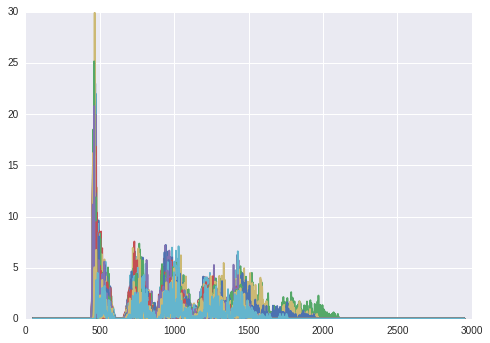

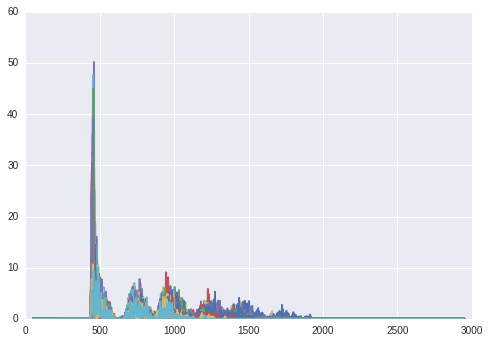

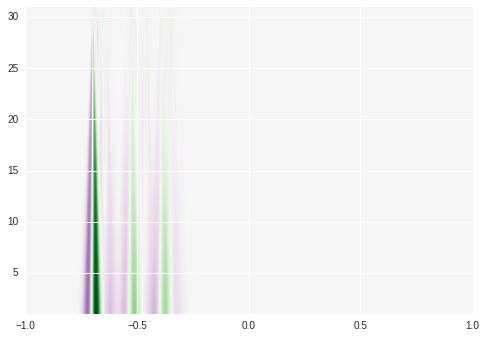

In [5]:
from scipy import signal

# sig_id = cldf == 'vbar'
# sig = df[sig_id.argsort()[-5],:]
# print(cldf[sig_id.argsort()[-4]])
# print(sig.shape)
sig = df[cldf == 'vbar', :]
t = range(3000)

plt.figure(0)
widths = np.arange(1, 31)
for s in sig:
    cwtmatr = signal.cwt(s, signal.ricker, widths)
    select = 3
    plt.plot(t[50:-50], np.abs(cwtmatr[select-1, 50:-50]), label=select)
plt.show()


sig = df[cldf == 'triangle', :]
t = range(3000)

plt.figure(1)
widths = np.arange(1, 31)
for s in sig:
    cwtmatr = signal.cwt(s, signal.ricker, widths)
    select = 3
    plt.plot(t[50:-50], np.abs(cwtmatr[select-1, 50:-50]), label=select)
plt.show()

plt.figure(2)
plt.imshow(cwtmatr, extent=[-1, 1, 1, 31], cmap='PRGn', aspect='auto',
           vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())

## Classificador

### Métrica - Dynamic Time Warping (DTW)

Dynamic time warping (DTW) é um algoritmo usado para comparar e alinhar duas séries temporais. Com ele é possível obter o alinhamento não-linear ótimo entre duas sequências de valores numéricos. Dessa maneira, é possível encontrar padrões entre medições de eventos com diferentes ritmos.

O DTW é um algoritmo de complexidade alta (O(N^2)), o que pode torná-lo lento quando a janela ou o tamanho da série é muito grande. Algumas implementações possuem otimizações que reduzem o custo computacional. No caso deste projeto foi utilizada a FastDTW.

Pseudo código:
```
int DTWDistance(s: array [1..n], t: array [1..m]) {
   DTW := array [0..n, 0..m]

   for i := 1 to n
       DTW[i, 0] := infinity
   for i := 1 to m
       DTW[0, i] := infinity
   DTW[0, 0] := 0

   for i := 1 to n
       for j := 1 to m
           cost := d(s[i], t[j])
           DTW[i, j] := cost + minimum(DTW[i-1, j  ],    // insertion
                                       DTW[i  , j-1],    // deletion
                                       DTW[i-1, j-1])    // match

   return DTW[n, m]
}
```

Imagine duas séries temporais, Q e C, de tamanhos n e m respectivamente, em que
```
Q = q1,q2,...,qi,...,qn
C = c1,c2,...,cj,...cm
```

O DTW tenta fazer o alinhamento dessas duas séries, primeiramente nós construímos uma matriz n x m em que o i-ésimo e o j-ésimo elementos da matriz correspondem ao calculo de distância d(qi , cj) = (qi – cj)^2, que é o alinhamento entre os pontos qi e cj. Na tentativa de encontrar o melhor alinhamento entre os sinais o algoritmo recuperar o caminho que minimiza a distância acumulada entre os pontos. O caminho ótimo é o caminho que minimiza o custo de deformação (_warping cost_).

Encontrar o _warping path_ (ou caminho de deformação) é normalmente uma tarefa que requer usar programação dinâmica, e portante precisa armazenar os valores passados para calcular os valores futuros com um custo menor. No algoritmo _dtw\_distance_, essa característica pode ser observada pelas seguintes instruções:
```
choices = cost[i - 1, j - 1], cost[i, j-1], cost[i-1, j]  # Acessando valores de calculos anteriores
cost[i, j] = min(choices) + dist(ts_a[i], ts_b[j])
``` 

Além dessa otimização inerente ao método, também é utilizada uma cache LRU para reduzir os calculos de distância. Isso torna a performance do método aleatória, mas com uma tendência alta de redução de custo, em troca de um consumo maior de memória.


### Agrupador - K-Nearest Neighbors Algorithm (K-NN)

K-Nearest Neighbor é um algoritmo utilizado para classificação e regressão. Em ambos os casos, o método consiste em encontrar "k" exemplos de treinamento mais próximos no espaço de busca. A saida depende do objetivo, como estamos trabalhando com classificação, a saída é a classe a qual o exemplo apresentado pertence. 

No entanto, se todos os itens do conjunto de treinamento forem utilizados pra o algoritmo do K-NN, a complexidade do cálculo do DTW tornaria o método impraticavel. Portanto, antes de executar o K-NN é feita uma clusterização simples utilizando o algoritmo KMeans, para agrupar os dados em clusters, e então, utilizar apenas o centroide (elemento central do cluster) para realizar o K-NN. Ambos os métodos executam cálculos de distância, porém o KMeans é executado com a distância euclidiana que possui uma complexidade linear e portanto permite que o KMeans encontre os centroides rapidamente.

Resumindo, o K-NN classifica baseado no elemento do conjunto de treino mais próximo do elemento do conjunto de teste. Após a aplicação do KMeans, o conjunto de testes é classificado, olhando para qual é a classe do centroide mais próximo. O KMeans utilizado no algoritmo a seguir (função _predict_) é um algoritmo simples porém muito eficiente para encontrar clusters. 

A biblioteca utilizida é a sklearn ou scikit-learn, essa biblioteca contêm vários métodos já implementados. A vantagem de usar a biblioteca é que a implementação deles é bastante otimizada e completa. No nosso caso, quase todos os parâmetros são default, exceto pelo número de clusters que nós colocamos um valor maior que o necessário (apenas 3 clusters ou 4 se separar o vbar/hbar). Por default, o método _sklearn.KMeans_ já executa 300 iterações, e 10 repetições, escolhendo a melhor distribuição de centroides entre elas.
```
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=12).fit(t_x)
cluster_centers = kmeans.cluster_centers_
kl = np.array([most_common(l[kmeans.labels_==i]) for i in range(len(cluster_centers))])
```
### Implementação KNN-DTW

A implementação completa do móudlo que combina o agrupador (KNN) com a métrica de distância para séries temporais (DTW) se encontra no directório _scripts_ no arquivo _project.py_.

Exemplo da distância DTW aplicada a duas senoides:

In [6]:
from functools import lru_cache
from scipy.stats import mode
import sys

have_ipython=True

class ProgressBar:
    """This progress bar was taken from PYMC
    """
    def __init__(self, iterations):
        self.iterations = iterations
        self.prog_bar = '[]'
        self.fill_char = '*'
        self.width = 40
        self.__update_amount(0)
        if have_ipython:
            self.animate = self.animate_ipython
        else:
            self.animate = self.animate_noipython

    def animate_ipython(self, iter):
        print('\r', self)
        sys.stdout.flush()
        self.update_iteration(iter + 1)

    def update_iteration(self, elapsed_iter):
        self.__update_amount((elapsed_iter / float(self.iterations)) * 100.0)
        self.prog_bar += '  %d of %s complete' % (elapsed_iter, self.iterations)

    def __update_amount(self, new_amount):
        percent_done = int(round((new_amount / 100.0) * 100.0))
        all_full = self.width - 2
        num_hashes = int(round((percent_done / 100.0) * all_full))
        self.prog_bar = '[' + self.fill_char * num_hashes + ' ' * (all_full - num_hashes) + ']'
        pct_place = (len(self.prog_bar) // 2) - len(str(percent_done))
        pct_string = '%d%%' % percent_done
        self.prog_bar = self.prog_bar[0:pct_place] + \
            (pct_string + self.prog_bar[pct_place + len(pct_string):])

    def __str__(self):
        return str(self.prog_bar)


@lru_cache(maxsize=None)
def dist(a, b):
    return np.linalg.norm(a-b)

def dtw_distance(ts_a, ts_b, max_warping_window=100):
    """Returns the DTW similarity distance between two 2-D
    timeseries numpy arrays.

    Arguments
    ---------
    ts_a, ts_b : array of shape [n_samples, n_timepoints]
        Two arrays containing n_samples of timeseries data
        whose DTW distance between each sample of A and B
        will be compared

    d : DistanceMetric object (default = abs(x-y))
        the distance measure used for A_i - B_j in the
        DTW dynamic programming function

    Returns
    -------
    DTW distance between A and B
    """

    # Create cost matrix via broadcasting with large int
    ts_a, ts_b = np.array(ts_a), np.array(ts_b)
    M, N = len(ts_a), len(ts_b)
    cost = sys.maxsize * np.ones((M, N))
    
    # Initialize the first row and column
    cost[0, 0] = dist(ts_a[0], ts_b[0])
    cost[1:, 0] = [cost[i-1, 0] + dist(ts_a[i], ts_b[0]) for i in range(1, M)]

    cost[0, 1:] = [cost[0, j-1] + dist(ts_a[0], ts_b[j]) for j in range(1, N)]

    # Populate rest of cost matrix within window
    for i in range(1, M):
        for j in range(max(1, i - max_warping_window),
                        min(N, i + max_warping_window)):
            choices = cost[i - 1, j - 1], cost[i, j-1], cost[i-1, j]
            cost[i, j] = min(choices) + dist(ts_a[i], ts_b[j])

    # Return DTW distance given window
    return cost[-1, -1]


def dist_matrix(x, y, subsample_step=1, warping_window_sz=100):
    """Computes the M x N distance matrix between the training
    dataset and testing dataset (y) using the DTW distance measure

    Arguments
    ---------
    x : array of shape [n_samples, n_timepoints]

    y : array of shape [n_samples, n_timepoints]

    Returns
    -------
    Distance matrix between each item of x and y with
        shape [training_n_samples, testing_n_samples]
    """

    # Compute the distance matrix
    dm_count = 0

    # Compute condensed distance matrix (upper triangle) of pairwise dtw distances
    # when x and y are the same array
    if(np.array_equal(x, y)):
        x_s = x.shape
        dm = np.zeros((x_s[0] * (x_s[0] - 1)) // 2, dtype=np.double)

        p = ProgressBar(dm.shape[0])

        for i in range(0, x_s[0] - 1):
            for j in range(i + 1, x_s[0]):
                dm[dm_count] = dtw_distance(x[i, ::subsample_step],
                                                  y[j, ::subsample_step], warping_window_sz)

                dm_count += 1
                p.animate(dm_count)

        # Convert to squareform
        dm = squareform(dm)
        return dm

    # Compute full distance matrix of dtw distnces between x and y
    else:
        x_s = np.shape(x)
        y_s = np.shape(y)
        dm = np.zeros((x_s[0], y_s[0]))
        dm_size = x_s[0]*y_s[0]

        p = ProgressBar(dm_size)

        for i in range(0, x_s[0]):
            for j in range(0, y_s[0]):
                dm[i, j] = dtw_distance(x[i, ::subsample_step],
                                              y[j, ::subsample_step], warping_window_sz)
                # Update progress bar
                dm_count += 1
                p.animate(dm_count)

        return dm
    
def most_common(coll):
    lst = list(coll)
    return max(lst, key=lst.count)

def centroid(arr):
    length = arr.shape[0]
    sum_x = np.sum(arr[:, 0])
    sum_y = np.sum(arr[:, 1])
    return sum_x/length, sum_y/length

def predict(x, t_x, l, n_neighbors=1, warping_window_sz=100):
    """Predict the class labels or probability estimates for
    the provided data

    Arguments
    ---------
      x : array of shape [n_samples, n_timepoints]
          Array containing the testing data set to be classified

    Returns
    -------
      2 arrays representing:
          (1) the predicted class labels
          (2) the knn label count probability
    """
    
    from sklearn.cluster import KMeans
    kmeans = KMeans(n_clusters=12).fit(t_x)
    cluster_centers = kmeans.cluster_centers_
    kl = np.array([most_common(l[kmeans.labels_==i]) for i in range(len(cluster_centers))])
          
    dm = dist_matrix(x, cluster_centers, warping_window_sz=warping_window_sz)
    print(dm)
    # Identify the k nearest neighbors
    knn_idx = dm.argsort()[:, :n_neighbors]
    print(knn_idx)

    # Identify k nearest labels
    knn_labels = kl[knn_idx]

    # Model Label
    mode_data = mode(knn_labels, axis=1)
    mode_label = mode_data[0]
    mode_proba = mode_data[1]/n_neighbors

    return mode_label.ravel(), mode_proba.ravel()

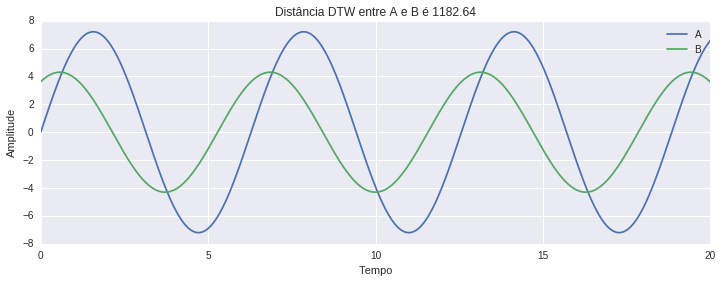

In [7]:
time = np.linspace(0,20,1000)
amplitude_a = 7.2*np.sin(time)
amplitude_b = 4.3*np.sin(time + 1)

distance = dtw_distance(amplitude_a, amplitude_b, int(len(time)*0.1))

fig = plt.figure(figsize=(12,4))
_ = plt.plot(time, amplitude_a, label='A')
_ = plt.plot(time, amplitude_b, label='B')
_ = plt.title('Distância DTW entre A e B é %.2f' % distance)
_ = plt.ylabel('Amplitude')
_ = plt.xlabel('Tempo')
_ = plt.legend()

In [8]:
# Remove o excesso de zeros

start_j = 0
print(df.shape)
for j in range(df.shape[1]):
    if df[:,j].any():
        start_j = j-min(10, j)
        break
    
end_j = 0
for j in range(df.shape[1]-1, 0, -1):
    if df[:,j].any():
        end_j = j+min(10, df.shape[1]-j)
        break

df = df[:, start_j:end_j]

x_train = [] #df[chosen,:]
y_train = [] #cldf[chosen]

x_test = [] #df[test_chosen,:]
y_test = [] #cldf[test_chosen]
    
for shape in shapes:
    mask = cldf == shape
    indexes = np.arange(df.shape[0])[mask]
    chosen = np.random.choice(indexes, replace=False, size=int(len(indexes)*0.6))
    test_chosen = [idx for idx in indexes if idx not in chosen]

    x_train.extend([df[i,:] for i in chosen])
    y_train.extend([cldf[i] for i in chosen])

    x_test.extend([df[i,:] for i in test_chosen])
    y_test.extend([cldf[i] for i in test_chosen])
    
x_train = np.array(x_train)
y_train = np.array(y_train)

x_test = np.array(x_test)
y_test = np.array(y_test)

y_train[y_train=='hbar'] = 'bar'
y_train[y_train=='vbar'] = 'bar'
y_test[y_test=='hbar'] = 'bar'
y_test[y_test=='vbar'] = 'bar'

print(x_test.shape)
    

(591, 3000)
(237, 1683)


In [9]:
step = 1

warping_win_sz = 160
label, proba = predict(x_test[::step], 
                       x_train[::step], y_train[::step], 
                       warping_window_sz = warping_win_sz)

 [                  0%                  ]
 [                  0%                  ]  2 of 2844 complete
 [                  0%                  ]  3 of 2844 complete
 [                  0%                  ]  4 of 2844 complete
 [                  0%                  ]  5 of 2844 complete
 [                  0%                  ]  6 of 2844 complete
 [                  0%                  ]  7 of 2844 complete
 [                  0%                  ]  8 of 2844 complete
 [                  0%                  ]  9 of 2844 complete
 [                  0%                  ]  10 of 2844 complete
 [                  0%                  ]  11 of 2844 complete
 [                  0%                  ]  12 of 2844 complete
 [                  0%                  ]  13 of 2844 complete
 [                  0%                  ]  14 of 2844 complete
 [                  1%                  ]  15 of 2844 complete
 [                  1%                  ]  16 of 2844 complete
 [                  1

/home/redrabbit/.pyenvs/pyquant/lib/python3.5/site-packages/scipy/stats/stats.py:249: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


### Resultados KNN-DTW

O código a seguir, apresenta os resultados da classificação para o método KNN-DTW através de uma matriz de confusão que indica os erros de classificação do método.

#### Interpretação da Matriz de Confusão (Confusion matrix)

A diagonal principal indica o número de acertos do método. As diagonais de fora, indicam os itens que foram classificados para uma classe diferente. A cor representa a proporção dos erros/acertos com relação ao total de amostras do conjunto de testes.

             precision    recall  f1-score   support

        bar       0.78      0.70      0.74       108
     square       0.86      0.55      0.67        69
   triangle       0.43      0.68      0.53        60

avg / total       0.72      0.65      0.67       237



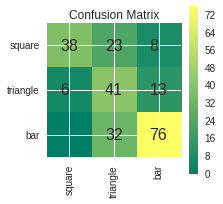

In [11]:
from matplotlib import cm
from sklearn.metrics import classification_report, confusion_matrix

print (classification_report(y_test[::step], label))

used_labels = ['square', 'triangle', 'bar']
nused = len(used_labels)
conf_mat = confusion_matrix(y_test[::step], label, labels=used_labels)

fig = plt.figure(figsize=(nused,nused))
width = np.shape(conf_mat)[1]
height = np.shape(conf_mat)[0]

res = plt.imshow(np.array(conf_mat), cmap=cm.summer, interpolation='nearest')
for i, row in enumerate(conf_mat):
    for j, c in enumerate(row):
        if c>0:
            plt.text(j-.2, i+.1, c, fontsize=16)
            
cb = fig.colorbar(res)
plt.title('Confusion Matrix')
_ = plt.xticks(range(nused), used_labels, rotation=90)
_ = plt.yticks(range(nused), used_labels)

(237, 1683) (237,) (237,) (237,)


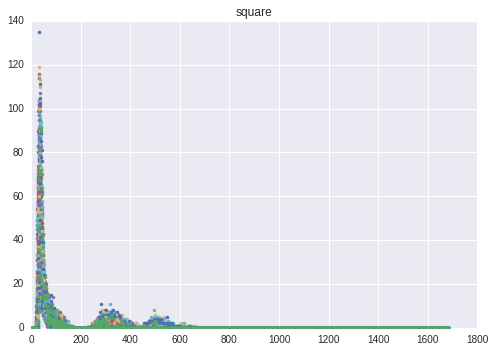

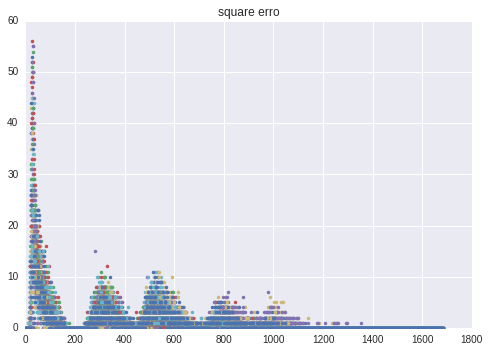

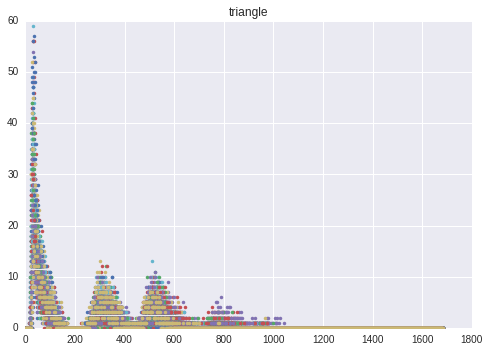

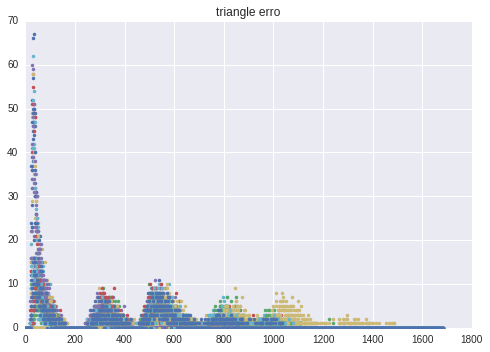

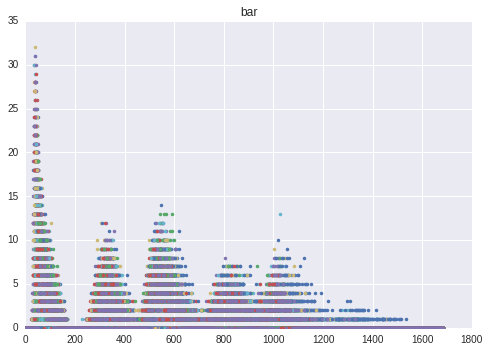

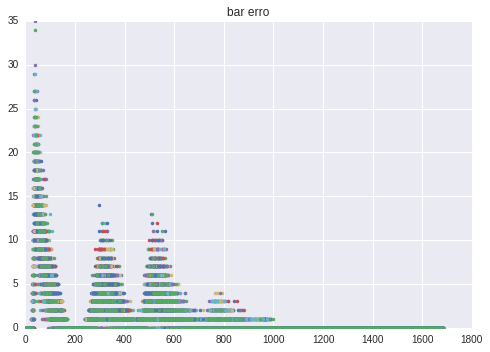

In [12]:
print (x_test.shape, label.shape, y_test.shape, ((y_test == 'square') * (label == 'square')).shape)


filt= lambda nm: ((y_test == nm) * (label == nm))
ifilt= lambda nm: ((y_test == nm) * (label != nm))

matches = x_test[filt('square'), :]
plt.figure(); _ = plt.plot(matches.T, '.')
plt.title("square")
matches = x_test[ifilt('square'), :]
plt.figure(); _ = plt.plot(matches.T, '.')
plt.title("square erro")

matches = x_test[filt('triangle'), :]
plt.figure(); _ = plt.plot(matches.T, '.')
plt.title("triangle")
matches = x_test[ifilt('triangle'), :]
plt.figure(); _ = plt.plot(matches.T, '.')
plt.title("triangle erro")

matches = x_test[filt('bar'), :]
plt.figure(); _ = plt.plot(matches.T, '.', label='bar')
plt.title("bar")
matches = x_test[ifilt('bar'), :]
plt.figure(); _ = plt.plot(matches.T, '.', label='bar erro')
plt.title("bar erro")

### Decision Tree Classifier

Classificação utilizando a técnica de DTC, que é indicada para problemas em que a estrutura do dado não é fixa. No caso deste problema, é uma série temporal que começa e termina em instantes diferentes para casa exemplo.

In [ ]:
from sklearn import tree

clf = tree.DecisionTreeClassifier()
clf = clf.fit(x_train, y_train)

In [ ]:
y_result = clf.predict(x_test)

print (classification_report(y_test[::step], y_result))

used_labels = ['square', 'triangle', 'bar']
nused = len(used_labels)
conf_mat = confusion_matrix(y_test[::step], y_result, labels=used_labels)

fig = plt.figure(figsize=(nused,nused))
width = np.shape(conf_mat)[1]
height = np.shape(conf_mat)[0]

res = plt.imshow(np.array(conf_mat), cmap=cm.summer, interpolation='nearest')
for i, row in enumerate(conf_mat):
    for j, c in enumerate(row):
        if c>0:
            plt.text(j-.2, i+.1, c, fontsize=16)
            
cb = fig.colorbar(res)
plt.title('Confusion Matrix')
_ = plt.xticks(range(nused), used_labels, rotation=90)
_ = plt.yticks(range(nused), used_labels)

In [ ]:
from sklearn.metrics import classification_report
y_true = [0, 1, 2, 1, 2]
y_pred = [0, 0, 2, 2, 1]
target_names = ['class 0', 'class 1', 'class 2']
print(classification_report(y_true, y_pred, target_names=target_names))

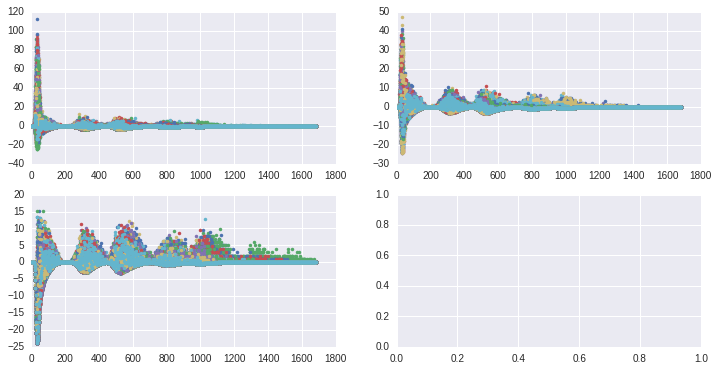

In [12]:
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
mu = np.mean(x_train, axis=0)
sd = np.std(x_train, axis=0)
x_train_d = (x_train-mu)
_ = ax1.plot(x_train_d[y_train == 'square',:].T, '.', label='square')
_ = ax2.plot(x_train_d[y_train == 'triangle',:].T, '.', label='triangle') 
_ = ax3.plot(x_train_d[y_train == 'bar',:].T, '.', label='bar')